<a href="https://colab.research.google.com/github/Marytem/Lane_detection/blob/master/unet_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ideas&TODOs

* add augmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')   

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import model
from DataGenerator import DataGenerator

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import *
import math

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

### Data generation

In [0]:
NO_OF_EPOCHS = 40
BATCH_SIZE = 8

data_dir = '/content/drive/My Drive/lane data/segm_structure/'
train_generator = DataGenerator(data_dir+'train_fr/train/',
                                data_dir+'train_masks/train/',
                                batch_size=BATCH_SIZE)
val_generator = DataGenerator(data_dir+'val_fr/val/',
                              data_dir+'val_masks/val/',
                              batch_size=BATCH_SIZE)

### Define model

In [4]:
m = model.unet()
m.load_weights('/content/drive/My Drive/lane data/weights/unet1_weights.h5')
m.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/content/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train

In [0]:
NO_OF_EPOCHS = 40
BATCH_SIZE = 8

weights_path = 'weights/easy/'
checkpoint = ModelCheckpoint(weights_path, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
csv_logger = CSVLogger('./log.out',
                       append=True,
                       separator=';')
earlystopping = EarlyStopping(monitor ='accuracy',
                              verbose = 1,
                              min_delta = 0.01,
                              patience = 3,
                              mode = 'max')
callbacks_list = [checkpoint, csv_logger, earlystopping]
train_steps = math.ceil(len(train_generator) / train_generator.batch_size)
val_steps = math.ceil(len(val_generator) / val_generator.batch_size)

In [0]:
results = m.fit_generator(train_generator, 
                          epochs=NO_OF_EPOCHS, 
                          validation_data=val_generator, 
                          validation_steps=val_steps,
                          steps_per_epoch=train_steps,
                          )

### See results

===================BATCH_16===================


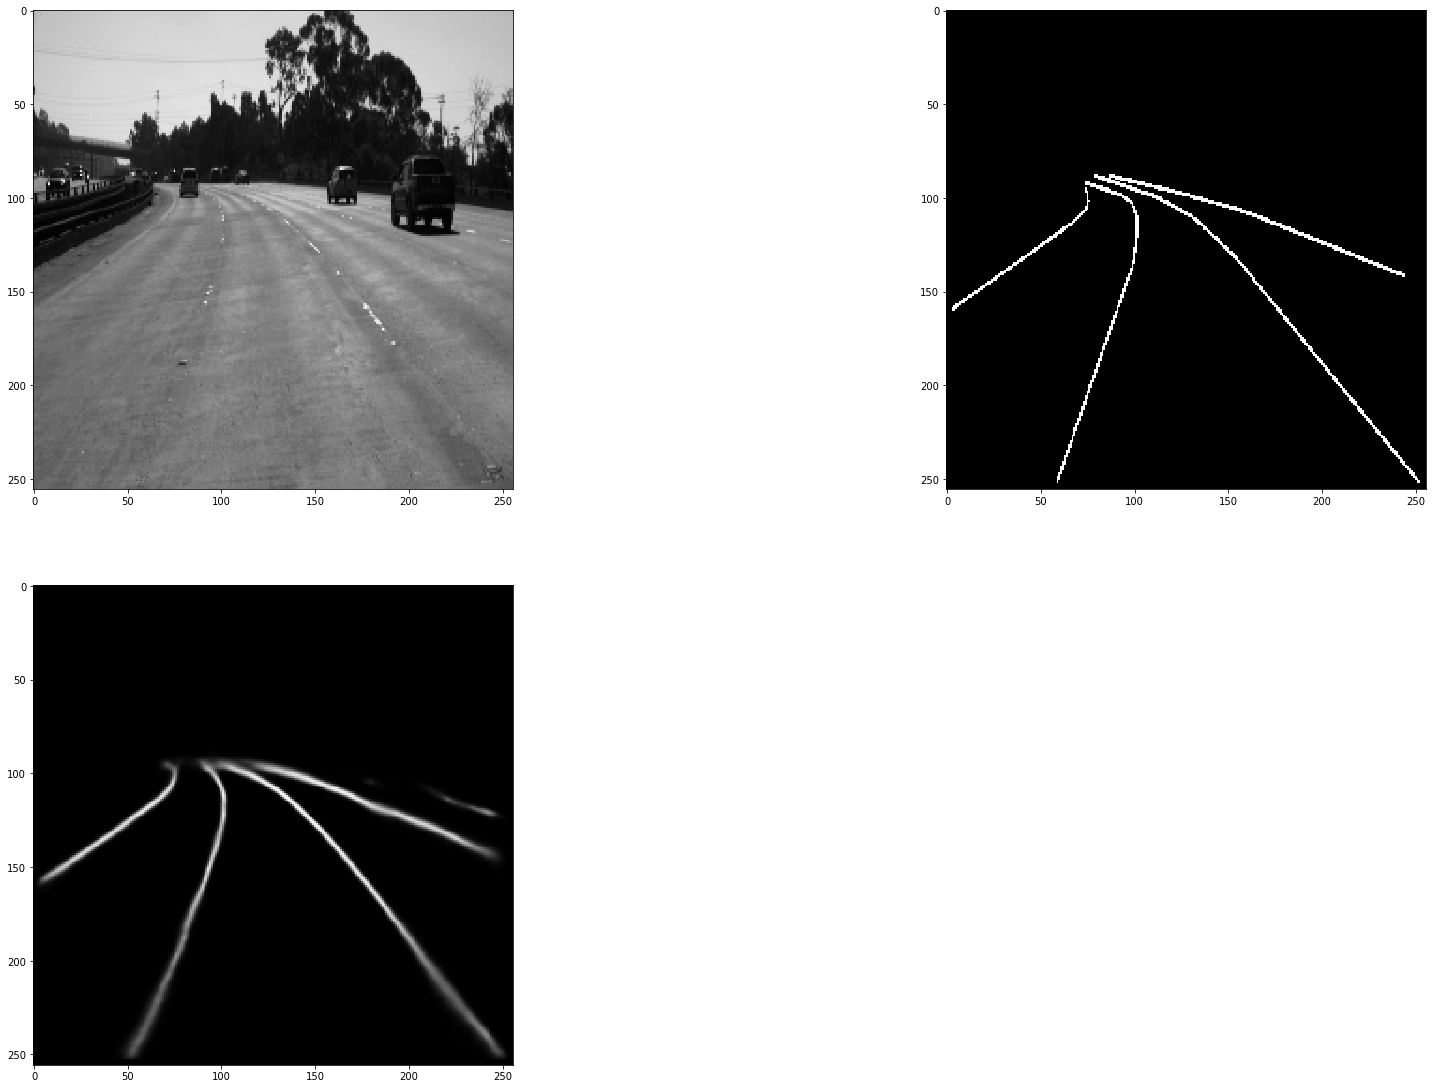

===================BATCH_4===================


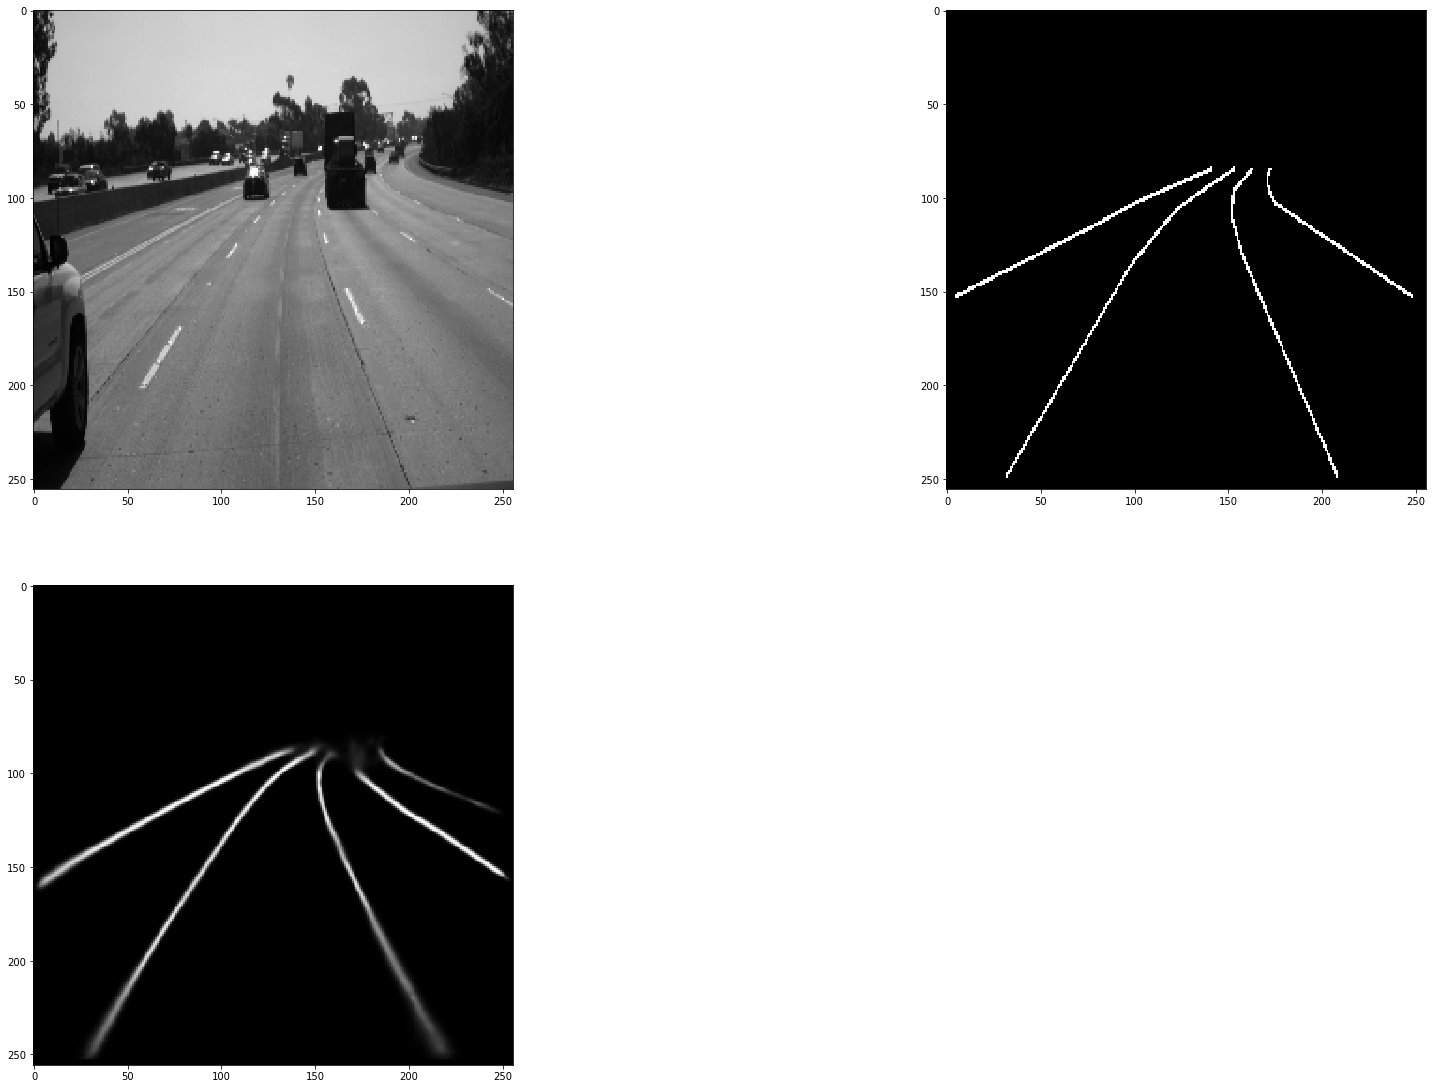

===================BATCH_23===================


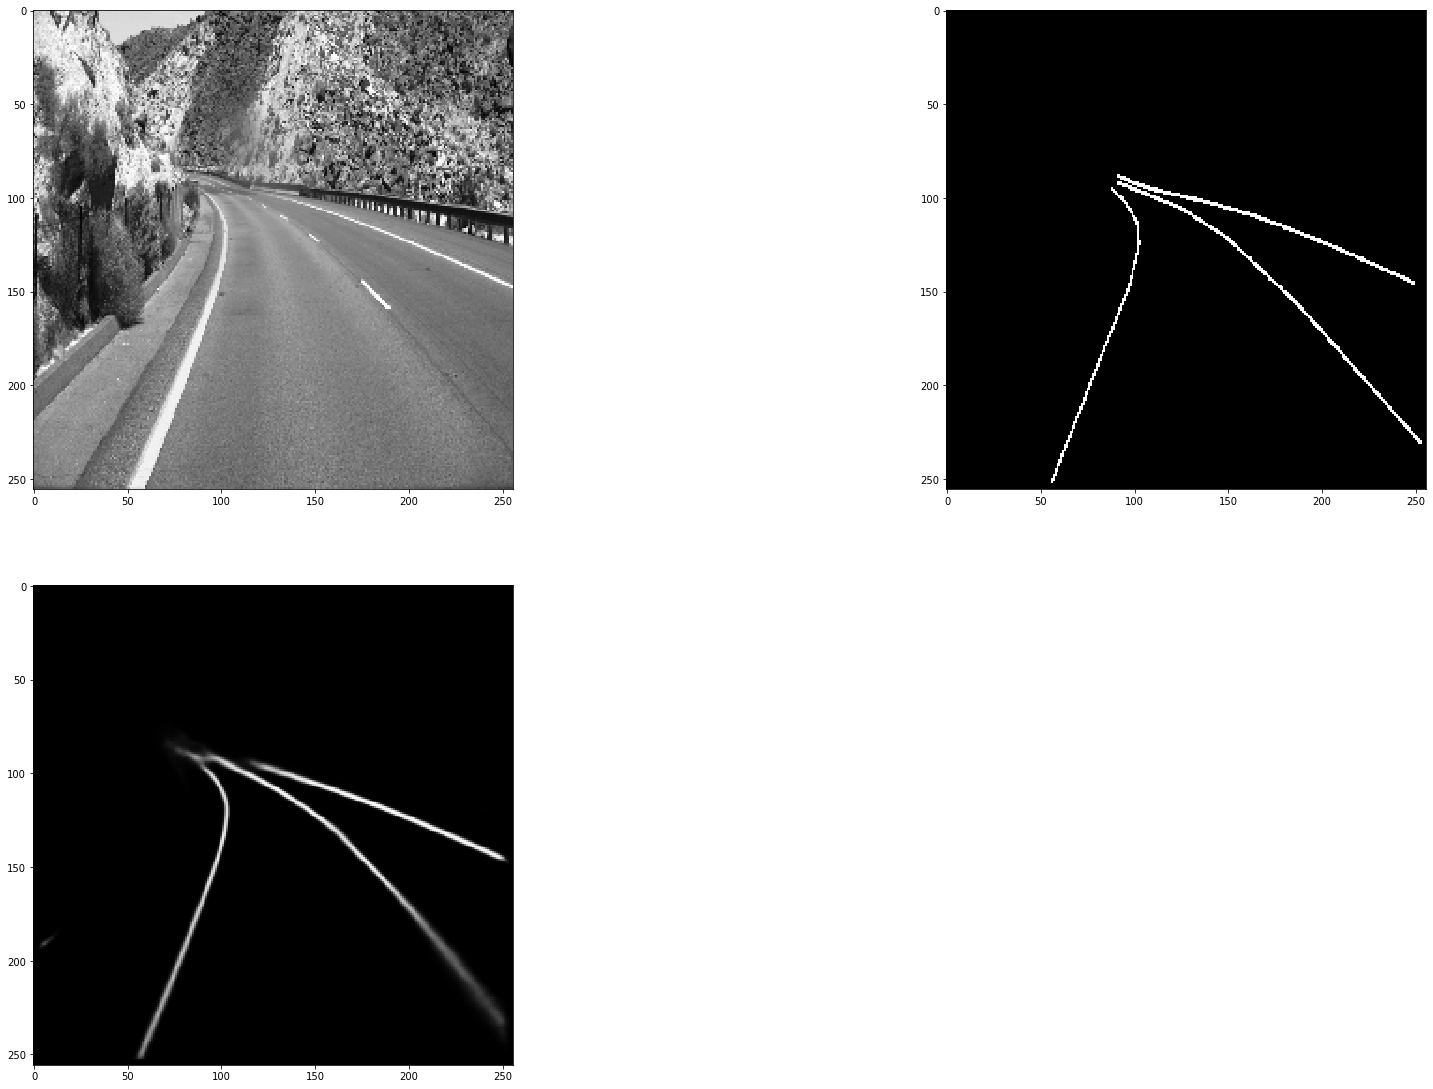

===================BATCH_34===================


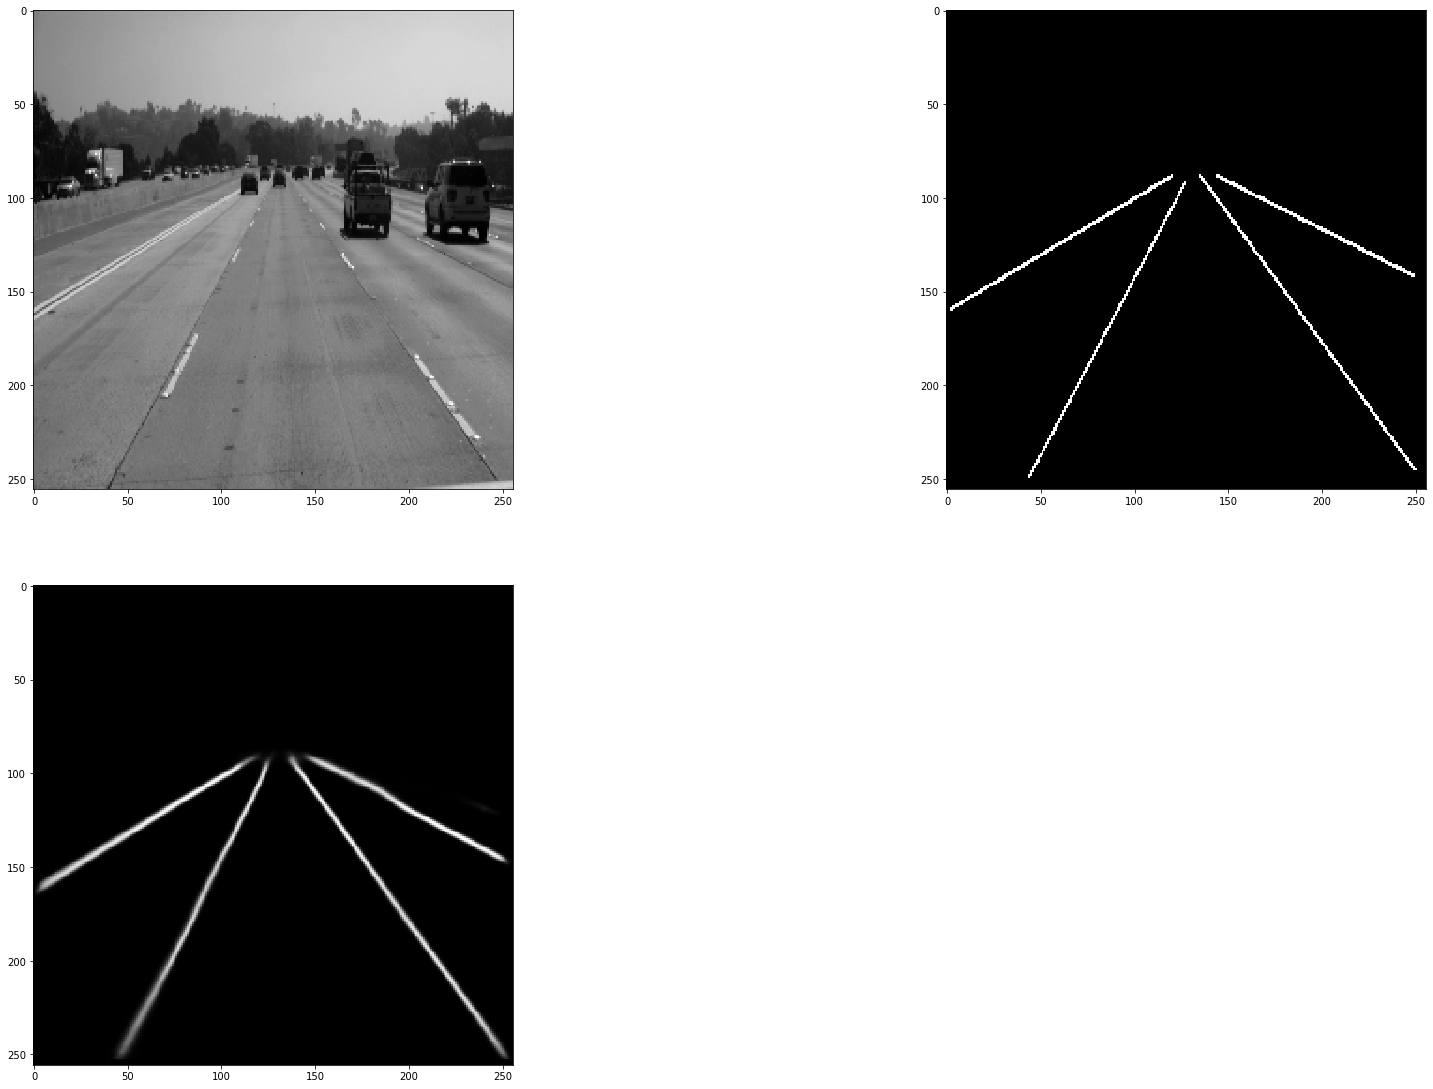

===================BATCH_44===================


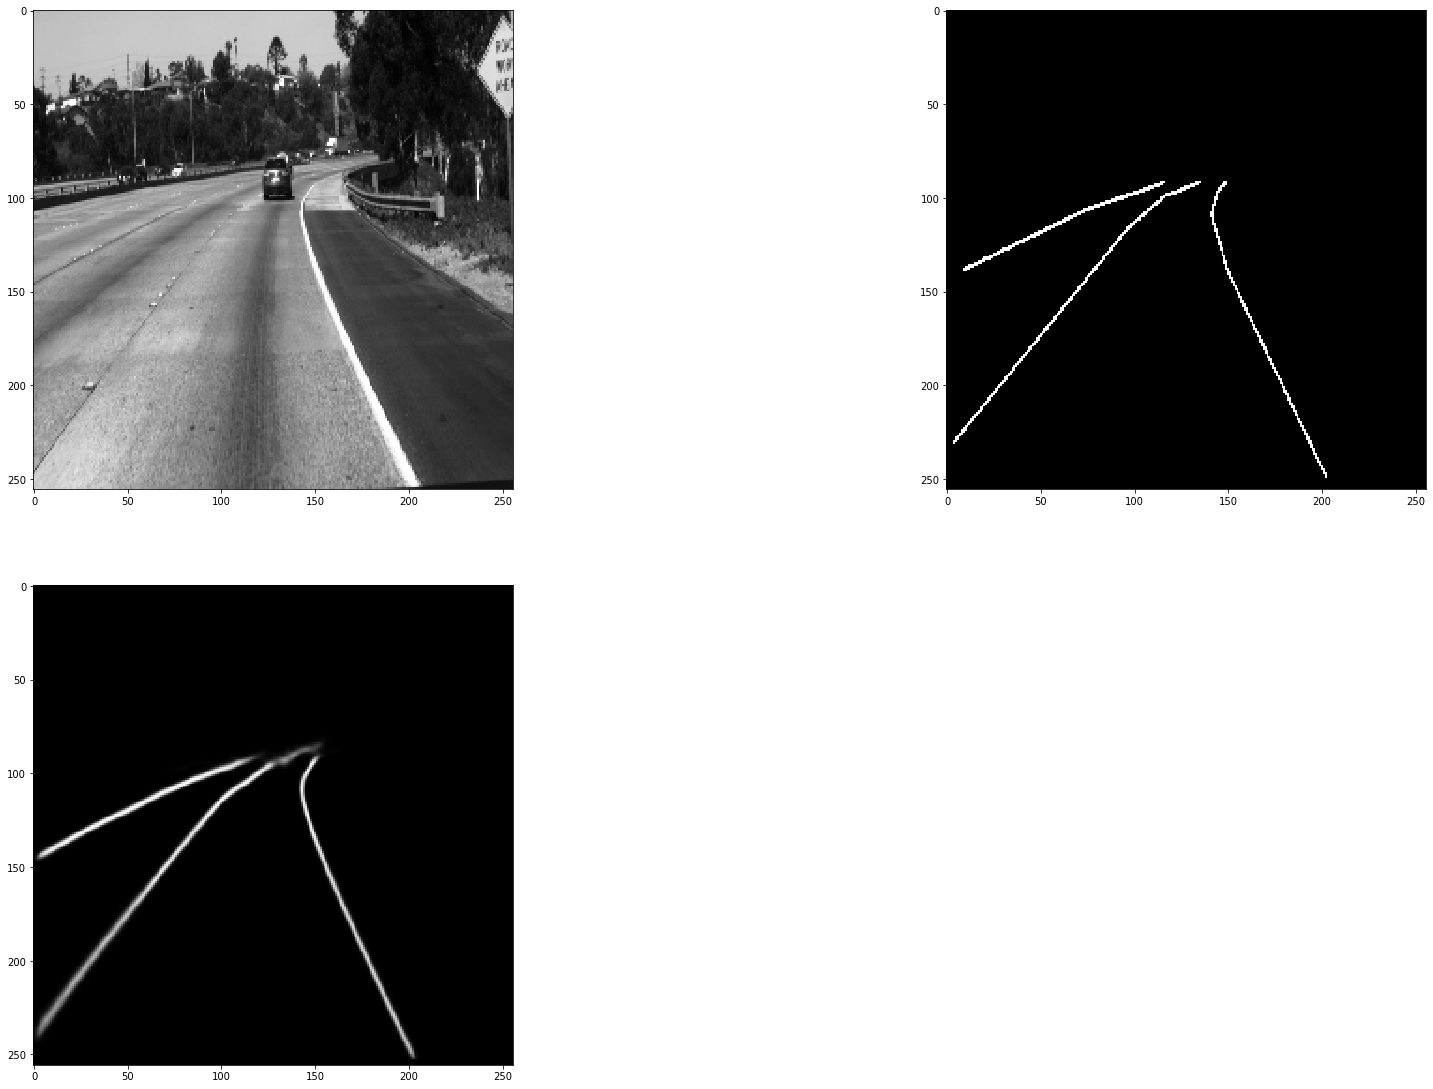

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_images(images, cmap=None):
    plt.figure(figsize=(30,30))
    for i, image in enumerate(images):
        plt.subplot(3,2,i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight=True)
    plt.show()


batch_inds = [16, 4, 23, 34, 44]
for batch_ind in batch_inds:
    print('===================BATCH_{}==================='.format(batch_ind))
    pred = m.predict(val_generator[batch_ind][0])[3]
    img = val_generator[batch_ind][0][3]
    mask = val_generator[batch_ind][1][3]

    display_images([np.reshape(img, (256,256)),
                    np.reshape(mask, (256,256)), 
                    np.reshape(pred, (256,256))],
                cmap='Greys_r')

plt.show()

### Save model

In [0]:
# m.save('Model.h5')

### Try complicated data

### Annotate video

In [0]:
def predict_one(frame):
    batch = np.zeros((8, 256, 256, 1))
    processed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    processed_frame = cv2.resize(processed_frame, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    processed_frame = np.reshape(processed_frame, (256, 256, 1))
    processed_frame = processed_frame/255
    batch[0] = processed_frame
    return m.predict(batch)[0]

def resize_image(image):
    pred = predict_one(image)
    resized = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    return resized

def create_annotated_frame(img):
    mask = predict_one(img)
    img  = img/255
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask = mask*2
    mask[:,:,2] = 0
    mask[:,:,1] = 0
    mask = mask.astype(img.dtype)
    annotated = cv2.addWeighted(img, 0.8, mask, 1, 0)
    return np.hstack((annotated, mask, img))

In [36]:

read_paths = [
            #   '/content/drive/My Drive/lane data/videos/Road - 1101.mp4', 
            #   '/content/drive/My Drive/lane data/videos/solidWhiteRight.mp4',
            #   '/content/drive/My Drive/lane data/videos/challenge.mp4',
              '/content/drive/My Drive/lane data/videos/city_night.mp4',
              '/content/drive/My Drive/lane data/videos/city_day.mp4'
              ]
write_paths = [
            #    '/content/drive/My Drive/lane data/output/road_101/', 
            #    '/content/drive/My Drive/lane data/output/solidwhite/', 
            #    '/content/drive/My Drive/lane data/output/challenge/', 
               '/content/drive/My Drive/lane data/output/city_night/',
               '/content/drive/My Drive/lane data/output/city_day/' 
               ]
# write frames
for r_path, w_path in zip(read_paths, write_paths):
    print('reading ' + r_path)
    clip = VideoFileClip(r_path)
    resized_clip = clip.fl_image(resize_image) 
    frames = np.array(list(resized_clip.iter_frames()))
    print('writing to ' + w_path)
    
    for i in range(len(frames)):
        ann = create_annotated_frame(frames[i])
        ann = ann*255
        ann = ann.astype('uint16')
        ann = cv2. cvtColor(ann, cv2. COLOR_BGR2RGB)
        cv2.imwrite(w_path + 'fr_{}.jpg'.format(i), ann)
        if i%50 == 0:
            print('...processed frame {}'.format(i))


reading /content/drive/My Drive/lane data/videos/city_night.mp4
writing to /content/drive/My Drive/lane data/output/city_night/
...processed frame 0
...processed frame 50
...processed frame 100
...processed frame 150
...processed frame 200
...processed frame 250
...processed frame 300
...processed frame 350
...processed frame 400
...processed frame 450
...processed frame 500
...processed frame 550
...processed frame 600
...processed frame 650
...processed frame 700
...processed frame 750
...processed frame 800
...processed frame 850
...processed frame 900
reading /content/drive/My Drive/lane data/videos/city_day.mp4
writing to /content/drive/My Drive/lane data/output/city_day/
...processed frame 0
...processed frame 50
...processed frame 100
...processed frame 150
...processed frame 200
...processed frame 250
...processed frame 300
...processed frame 350
...processed frame 400
...processed frame 450
...processed frame 500
...processed frame 550
...processed frame 600
...processed frame

In [37]:
# write videos
for path in write_paths:
    imgs = os.listdir(path)
    clips = [ImageClip(path + m).set_duration(0.1) for m in imgs]
    concat_clip = concatenate_videoclips(clips, method="compose")
    concat_clip.write_videofile(path + 'unet_vid.mp4', fps=24)

[MoviePy] >>>> Building video /content/drive/My Drive/lane data/output/city_night/unet_vid.mp4
[MoviePy] Writing video /content/drive/My Drive/lane data/output/city_night/unet_vid.mp4


100%|██████████| 2196/2196 [00:29<00:00, 73.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/lane data/output/city_night/unet_vid.mp4 

[MoviePy] >>>> Building video /content/drive/My Drive/lane data/output/city_day/unet_vid.mp4
[MoviePy] Writing video /content/drive/My Drive/lane data/output/city_day/unet_vid.mp4


100%|██████████| 1954/1954 [00:28<00:00, 69.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/lane data/output/city_day/unet_vid.mp4 

